# Proyecto Árboles de Decisión: *Predicción del diagnóstico de diabetes*

### 1. Análisis Exploratorio de Datos (EDA)

### 1.1. Exploración preliminar de los datos

In [52]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree, export_text, DecisionTreeRegressor
from sklearn.metrics import *
from imblearn.metrics import specificity_score
from sklearn.model_selection import GridSearchCV
from joblib import dump

In [2]:
df = pd.read_csv('/workspaces/Celia_Decision_Tree/data/raw/diabetes_prediction_dataset.csv')

In [3]:
df

,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level,diabetes
0,Female,80.0,0,1,never,25.19,6.6,140,0
1,Female,54.0,0,0,No Info,27.32,6.6,80,0
2,Male,28.0,0,0,never,27.32,5.7,158,0
3,Female,36.0,0,0,current,23.45,5.0,155,0
4,Male,76.0,1,1,current,20.14,4.8,155,0
...,...,...,...,...,...,...,...,...,...
99995,Female,80.0,0,0,No Info,27.32,6.2,90,0
99996,Female,2.0,0,0,No Info,17.37,6.5,100,0
99997,Male,66.0,0,0,former,27.83,5.7,155,0
99998,Female,24.0,0,0,never,35.42,4.0,100,0


In [4]:
df.shape

(100000, 9)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 9 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   gender               100000 non-null  object 
 1   age                  100000 non-null  float64
 2   hypertension         100000 non-null  int64  
 3   heart_disease        100000 non-null  int64  
 4   smoking_history      100000 non-null  object 
 5   bmi                  100000 non-null  float64
 6   HbA1c_level          100000 non-null  float64
 7   blood_glucose_level  100000 non-null  int64  
 8   diabetes             100000 non-null  int64  
dtypes: float64(3), int64(4), object(2)
memory usage: 6.9+ MB


In [6]:
df.nunique()

gender                    3
age                     102
hypertension              2
heart_disease             2
smoking_history           6
bmi                    4247
HbA1c_level              18
blood_glucose_level      18
diabetes                  2
dtype: int64

In [7]:
df.duplicated().sum() # 3854 duplicados

3854

In [8]:
df.drop(df[df.duplicated()].index, axis=0, inplace=True)

In [9]:
len(df)

96146

In [10]:
df.isnull().mean()*100

gender                 0.0
age                    0.0
hypertension           0.0
heart_disease          0.0
smoking_history        0.0
bmi                    0.0
HbA1c_level            0.0
blood_glucose_level    0.0
diabetes               0.0
dtype: float64

*Conclusiones preliminares:*
- *Dataset inicial con 9 variables, 2 de ellas categóricas (las cuales habrá que transformar posteriormente).*
- *100000 pacientes, sin datos faltantes*.
- *3854 duplicados, por lo que se nos quedan 96146 filas.*
- *Target binario: padecer o no diabetes.*


### 1.2. Exploración del target binario: *padecer o no diabetes*

*Como se puede observar en el primer gráfico, el target está muy desbalanceado, por lo que vamos a proceder a hacer submuestro o undersampling, es decir, reducir el número de instancias de la clase mayoritaria para igualar ambas clases. Seguimos 2 estrategias:*

- *En primer lugar, ir reduciendo poco a poco las instancias con valor 0 para el target, pero no aleatoriamente, si no teniendo en cuenta cuáles contienen menos información valiosa (como las de la categoría "no info" para la variable "smoking_story") o cuáles pueden ayudarnos a equilibrar otras variables desbalanceadas si las eliminamos, como en el caso de "gender", "heart_disease", etc.*

- *En segundo lugar, para completar el submuestreo sí hemos realizado una reducción aleatoria.*

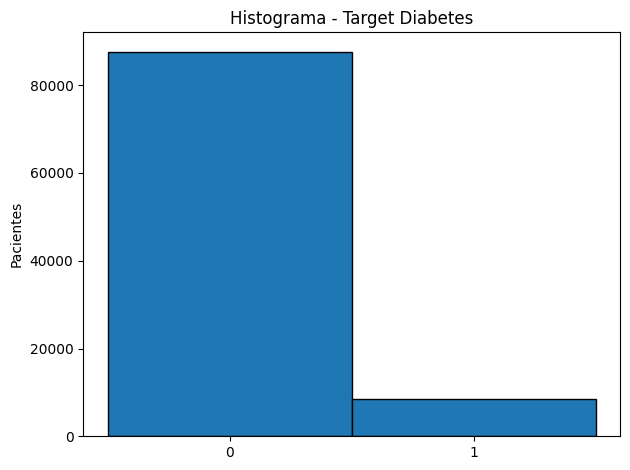

In [11]:
plt.hist(df['diabetes'], bins = 2, edgecolor='black')
plt.xticks([0.25, 0.75], ['0', '1'])
plt.title('Histograma - Target Diabetes')
plt.ylabel('Pacientes')


plt.tight_layout()
plt.show()

In [12]:
positive_diabetes = (df.diabetes == 1).sum()
negative_diabetes = (df.diabetes == 0).sum()
print(f'Pacientes con diabetes: {positive_diabetes}')
print(f'Pacientes sanos: {negative_diabetes}')

Pacientes con diabetes: 8482
Pacientes sanos: 87664


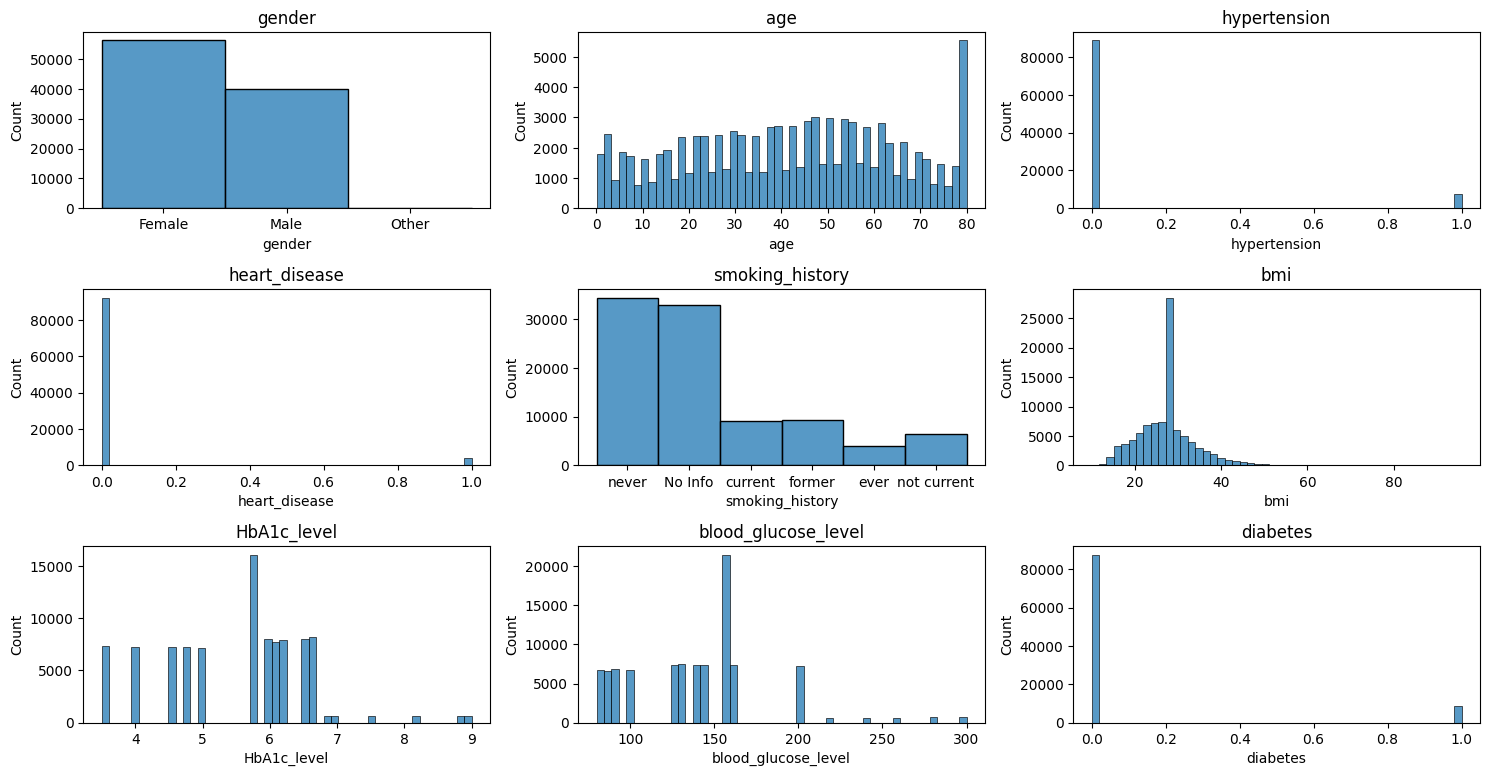

In [13]:
# Representamos las variables numéricas mediante histogramas para observar las distribución de los datos
plt.figure(figsize=(15, 10))

for i, col in enumerate(df.columns): 
    plt.subplot(4, 3, i+1) 
    sns.histplot(data=df, x=col, bins = 50) 
    plt.title(col)  

plt.tight_layout()  
plt.show()

In [14]:
df_filtrado= df[~((df['diabetes'] == 0) & (df['smoking_history'] == 'No Info') & ((df['gender'] == 'Female') | (df['gender'] == 'Other')))]
df_filtrado

,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level,diabetes
0,Female,80.0,0,1,never,25.19,6.6,140,0
2,Male,28.0,0,0,never,27.32,5.7,158,0
3,Female,36.0,0,0,current,23.45,5.0,155,0
4,Male,76.0,1,1,current,20.14,4.8,155,0
5,Female,20.0,0,0,never,27.32,6.6,85,0
...,...,...,...,...,...,...,...,...,...
99992,Female,26.0,0,0,never,34.34,6.5,160,0
99993,Female,40.0,0,0,never,40.69,3.5,155,0
99997,Male,66.0,0,0,former,27.83,5.7,155,0
99998,Female,24.0,0,0,never,35.42,4.0,100,0


In [15]:
df_filtrado_2 = df_filtrado[~((df_filtrado['diabetes'] == 0) & (df_filtrado['smoking_history'] == 'No Info') & (df_filtrado['heart_disease'] == 0))]

df_filtrado_2

,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level,diabetes
0,Female,80.0,0,1,never,25.19,6.6,140,0
2,Male,28.0,0,0,never,27.32,5.7,158,0
3,Female,36.0,0,0,current,23.45,5.0,155,0
4,Male,76.0,1,1,current,20.14,4.8,155,0
5,Female,20.0,0,0,never,27.32,6.6,85,0
...,...,...,...,...,...,...,...,...,...
99992,Female,26.0,0,0,never,34.34,6.5,160,0
99993,Female,40.0,0,0,never,40.69,3.5,155,0
99997,Male,66.0,0,0,former,27.83,5.7,155,0
99998,Female,24.0,0,0,never,35.42,4.0,100,0


In [16]:
df_filtrado_3 = df_filtrado_2[~((df_filtrado_2['diabetes'] == 0) & (df_filtrado_2['gender'] == 'Female') & (df_filtrado_2['heart_disease'] == 0)& (df_filtrado_2['age'] >= 75))]

In [17]:
df_filtrado_4 = df_filtrado_3[~((df_filtrado_3['diabetes'] == 0) & (df_filtrado_3['smoking_history'] == 'Never') )]

In [18]:
df_filtrado_5 = df_filtrado_4[~((df_filtrado_3['diabetes'] == 0) & (df_filtrado_4['heart_disease'] == 0) & (df_filtrado_4['gender'] == 'Female') & (df_filtrado_4['hypertension'] == 0) & (df_filtrado_4['smoking_history'] == 'Never') )]

In [19]:
filas_eliminar = df_filtrado_5[(df_filtrado_5['diabetes'] == 0) & (df_filtrado_5['gender'] == 'Female')].sample(10000)
df_filtrado_6 = df_filtrado_5.drop(filas_eliminar.index)

In [20]:
filas_eliminar_female = df_filtrado_6[(df_filtrado_6['diabetes'] == 0) & (df_filtrado_6['gender'] == 'Female')].sample(15000)
filas_eliminar_male = df_filtrado_6[(df_filtrado_6['diabetes'] == 0) & (df_filtrado_6['gender'] == 'Male')].sample(15000)
filas_eliminar = pd.concat([filas_eliminar_female, filas_eliminar_male])


df_filtrado_7 = df_filtrado_6.drop(filas_eliminar.index)

In [21]:
df_filtrado_7

,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level,diabetes
4,Male,76.0,1,1,current,20.14,4.8,155,0
6,Female,44.0,0,0,never,19.31,6.5,200,1
8,Male,42.0,0,0,never,33.64,4.8,145,0
10,Female,53.0,0,0,never,27.32,6.1,85,0
23,Female,72.0,0,1,former,27.94,6.5,130,0
...,...,...,...,...,...,...,...,...,...
99976,Male,13.0,0,0,never,21.01,4.8,140,0
99978,Male,14.0,0,0,never,23.67,5.8,145,0
99979,Female,61.0,0,0,current,30.11,6.2,240,1
99987,Female,23.0,0,0,never,17.87,5.8,100,0


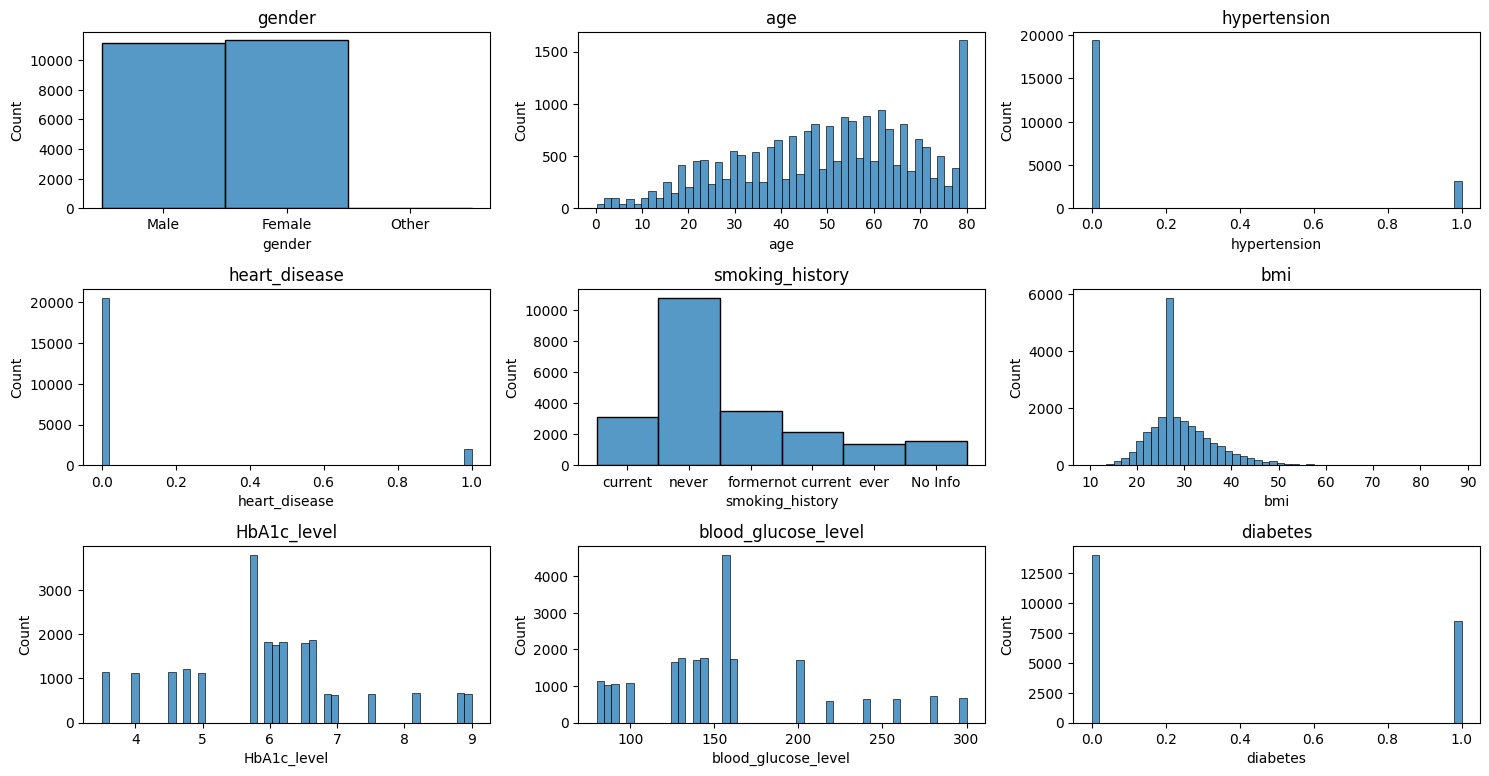

In [23]:
plt.figure(figsize=(15, 10))

for i, col in enumerate(df_filtrado_6.columns): 
    plt.subplot(4, 3, i+1) 
    sns.histplot(data=df_filtrado_7, x=col, bins = 50) 
    plt.title(col)  

plt.tight_layout()  
plt.show()

In [24]:
filas_no_other = (df_filtrado_7['gender'] != "Other") # Eliminas las 12 filas con valor "other" para la variable "Gender"
ds = df_filtrado_7[filas_no_other]
ds

,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level,diabetes
4,Male,76.0,1,1,current,20.14,4.8,155,0
6,Female,44.0,0,0,never,19.31,6.5,200,1
8,Male,42.0,0,0,never,33.64,4.8,145,0
10,Female,53.0,0,0,never,27.32,6.1,85,0
23,Female,72.0,0,1,former,27.94,6.5,130,0
...,...,...,...,...,...,...,...,...,...
99976,Male,13.0,0,0,never,21.01,4.8,140,0
99978,Male,14.0,0,0,never,23.67,5.8,145,0
99979,Female,61.0,0,0,current,30.11,6.2,240,1
99987,Female,23.0,0,0,never,17.87,5.8,100,0


*Conclusiones target:*
- *Data set final balanceado: 22536 instancias.*
- *Por otro lado, en cuanto a las variables numéricas (7), observamos bastantes outlayers, pero no vamos a realizar winsorización porque los valores atípicos resultan interesantes en este estudio.*

### 1.3. Modificación variables categóricas

In [25]:
# Separamos en variables numéricas y categóricas
#categorical_cols = ['gender', 'smoking_history']
#df_cat = df[categorical_cols]
#df_num = df.drop(df[categorical_cols], axis = 1)

In [26]:
# Transformamos la variable 'gender' en binario
ds['gender'] = ds['gender'].map({'Female': 0, 'Male': 1})

/tmp/ipykernel_617/2867463098.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ds['gender'] = ds['gender'].map({'Female': 0, 'Male': 1})


In [27]:
ds.head()

,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level,diabetes
4,1,76.0,1,1,current,20.14,4.8,155,0
6,0,44.0,0,0,never,19.31,6.5,200,1
8,1,42.0,0,0,never,33.64,4.8,145,0
10,0,53.0,0,0,never,27.32,6.1,85,0
23,0,72.0,0,1,former,27.94,6.5,130,0


In [28]:
# Transformamos la variable "smoking_history" mediante one hot encoding
ds = pd.get_dummies(ds, columns=['smoking_history'], prefix='smoking')


In [29]:
ds = ds.astype(int)

In [30]:
ds.drop('smoking_No Info', axis = 1, inplace = True)

In [31]:
ds

,gender,age,hypertension,heart_disease,bmi,HbA1c_level,blood_glucose_level,diabetes,smoking_current,smoking_ever,smoking_former,smoking_never,smoking_not current
4,1,76,1,1,20,4,155,0,1,0,0,0,0
6,0,44,0,0,19,6,200,1,0,0,0,1,0
8,1,42,0,0,33,4,145,0,0,0,0,1,0
10,0,53,0,0,27,6,85,0,0,0,0,1,0
23,0,72,0,1,27,6,130,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
99976,1,13,0,0,21,4,140,0,0,0,0,1,0
99978,1,14,0,0,23,5,145,0,0,0,0,1,0
99979,0,61,0,0,30,6,240,1,1,0,0,0,0
99987,0,23,0,0,17,5,100,0,0,0,0,1,0


### 1.3. Análisis multivariante - Selección de características

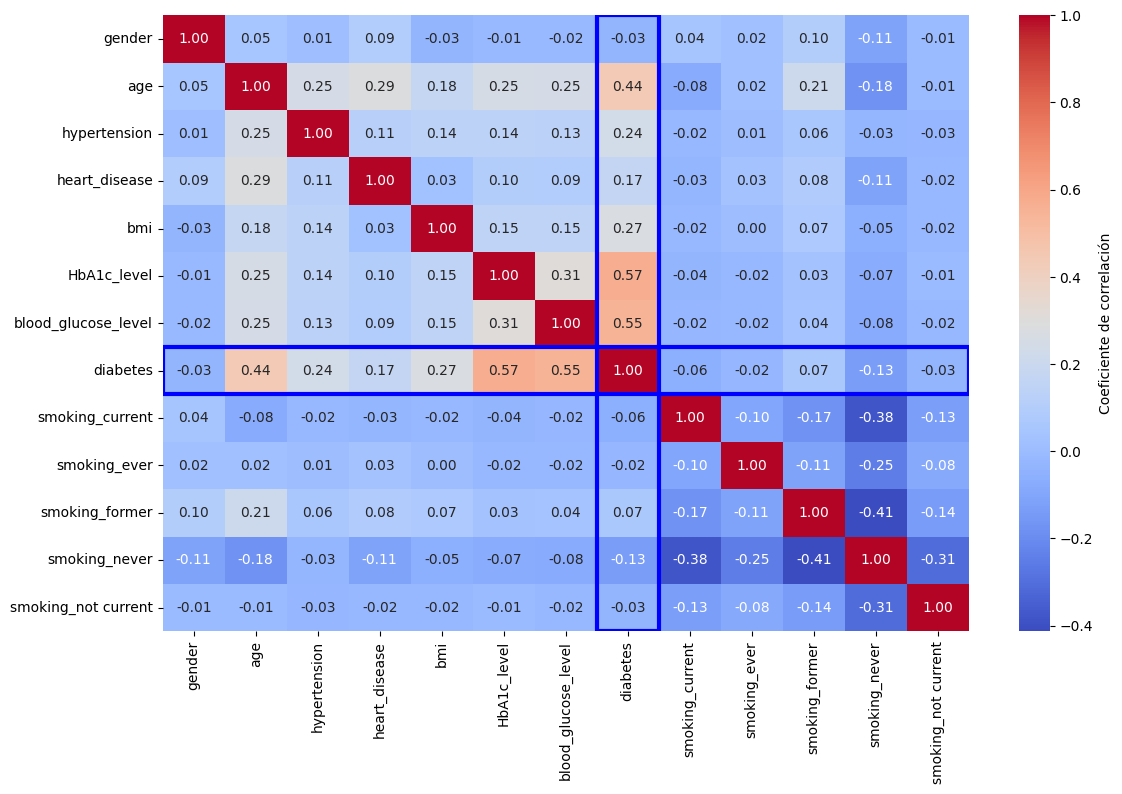

In [32]:
# Realizamos el gradiente de correlaciones
corr = ds.corr()

def corr_highlighted_target(corr, target):
   
    
    plt.figure(figsize=(13, 8))

    sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm', cbar_kws={'label': 'Coeficiente de correlación'})

    target_index = corr.columns.tolist().index(target)

    plt.gca().add_patch(plt.Rectangle((target_index, 0), 1, len(corr), fill=False, edgecolor='blue', lw=3))
    plt.gca().add_patch(plt.Rectangle((0, target_index), len(corr), 1, fill=False, edgecolor='blue', lw=3))

    plt.show()
   


corr_highlighted_target(corr, 'diabetes')

In [33]:
# Factor de inflación de la varianza
vif = pd.Series([variance_inflation_factor(corr.values, i) for i in range(corr.shape[1])], index=ds.columns)
vif

gender                  1.130813
age                     3.749809
hypertension            1.579225
heart_disease           1.628409
bmi                     1.537128
HbA1c_level             4.558257
blood_glucose_level     4.033329
diabetes               16.952802
smoking_current        29.923703
smoking_ever           13.705091
smoking_former         33.373507
smoking_never          74.483104
smoking_not current    20.353814
dtype: float64

In [34]:
dt = ds.drop(['smoking_current','smoking_ever','smoking_former','smoking_not current'], axis = 1, inplace = True)

In [35]:
# Factor de inflación de la varianza corregido
corr = ds.corr()
vif = pd.Series([variance_inflation_factor(corr.values, i) for i in range(corr.shape[1])], index=ds.columns)
vif

gender                  1.108609
age                     3.440350
hypertension            1.510838
heart_disease           1.528847
bmi                     1.495262
HbA1c_level             4.551154
blood_glucose_level     4.029940
diabetes               13.662524
smoking_never           1.260072
dtype: float64

*Conclusiones análisis multivariante:*

- *Observamos como claramente muchas de las características tienen una influencia directa sobre el target, como "age", "blood_glucose_level", "hypertension" o "bmi".*
- *Otras características como "smoking" o "gender" no guardan tanta correlación con la variable respuesta, pero siempre pueden aportar riqueza al modelo.*
- *Importante: no es necesario escalar los datos, ya que los árboles de decisión NO son algoritmos sensibles a escala.*

### 2.Entrenamiento del modelo: Decision Tree

*Estrategias a seguir:*

*1. Se crea un modelo de Decision Tree complejo, con muchas ramas y profundidad.*

*2. A su vez, se crea también un modelo con un árbol muy simple. De esta manera, podremos comprobar las diferencias de métricas entre ambos modelos extremos.*

*3. Se realiza un GridSearch pra buscar los mejores hiperparámetros para este modelo concreto, que será el definitivo.*

In [40]:
# Procedemos a generar los conjuntos de entrenamiento y de testeo
X_train, X_test, y_train, y_test = train_test_split(ds.drop(['diabetes'], axis=1), ds['diabetes'], test_size=0.2, random_state=63)

In [41]:
# Crear un árbol de decisión complejo
complex_tree = DecisionTreeClassifier(max_depth=100, min_samples_leaf=1, random_state=42)
complex_tree.fit(X_train, y_train)


simple_tree = DecisionTreeClassifier(max_depth=3, min_samples_leaf=20, max_features=X_train.shape[1], random_state=42)
simple_tree.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=3, max_features=8, min_samples_leaf=20,
                       random_state=42)

In [42]:
# Evaluar el modelo complejo en entrenamiento y prueba
train_pred_complex = complex_tree.predict(X_train)
test_pred_complex = complex_tree.predict(X_test)

# Evaluar el modelo simple en entrenamiento y prueba
train_pred_simple = simple_tree.predict(X_train)
test_pred_simple = simple_tree.predict(X_test)

In [46]:
def get_metrics(y_train, y_test, y_pred_train, y_pred_test):
    # Calcular métricas para el conjunto de entrenamiento
    train_accuracy = accuracy_score(y_train, y_pred_train)
    train_f1 = f1_score(y_train, y_pred_train)
    train_auc = roc_auc_score(y_train, y_pred_train)
    train_precision = precision_score(y_train, y_pred_train)
    train_recall = recall_score(y_train, y_pred_train)
    train_specificity = specificity_score(y_train, y_pred_train)

    # Calcular métricas para el conjunto de prueba
    test_accuracy = accuracy_score(y_test, y_pred_test)
    test_f1 = f1_score(y_test, y_pred_test)
    test_auc = roc_auc_score(y_test, y_pred_test)
    test_precision = precision_score(y_test, y_pred_test)
    test_recall = recall_score(y_test, y_pred_test)
    test_specificity = specificity_score(y_test, y_pred_test)

    # Calcular la diferencia entre métricas de entrenamiento y prueba
    diff_accuracy = train_accuracy - test_accuracy
    diff_f1 = train_f1 - test_f1
    diff_auc = train_auc - test_auc
    diff_precision = train_precision - test_precision
    diff_recall = train_recall - test_recall
    diff_specificity = train_specificity - test_specificity

    # Crear un DataFrame con los resultados
    metrics_df = pd.DataFrame([[train_accuracy, train_f1, train_auc, train_precision, train_recall, train_specificity],[test_accuracy, test_f1, test_auc, test_precision, test_recall, test_specificity],[diff_accuracy, diff_f1, diff_auc, diff_precision, diff_recall, diff_specificity]],
                              columns = ['Accuracy', 'F1', 'AUC', 'Precision', 'Recall', 'Specificity'],
                              index = ['Train','Test', 'Diferencia'])

    return metrics_df

In [47]:
# Métricas del modelo complejo
get_metrics(y_train, y_test, train_pred_complex, test_pred_complex)

,Accuracy,F1,AUC,Precision,Recall,Specificity
Train,0.994228,0.992270,0.992555,0.998803,0.985822,0.999289
Test,0.866149,0.823323,0.857429,0.825499,0.821157,0.893701
Diferencia,0.128080,0.168947,0.135126,0.173304,0.164665,0.105588


In [48]:
# Métricas del modelo simple
get_metrics(y_train, y_test, train_pred_simple, test_pred_simple)

,Accuracy,F1,AUC,Precision,Recall,Specificity
Train,0.858760,0.768573,0.812066,1.0,0.624132,1.0
Test,0.853274,0.760594,0.806838,1.0,0.613676,1.0
Diferencia,0.005486,0.007979,0.005228,0.0,0.010456,0.0


- *El modelo complejo muestra un claro caso de sobreajuste, evidenciado por la diferencia significativa entre las métricas del conjunto de train y las del conjunto de test.*

- *Aunque el modelo simple parece generalizar mejor al tener diferencias mínimas entre los conjuntos, su baja precisión y F1 Score indican que no captura adecuadamente la complejidad de los datos.*

- *En resumen, ambos modelos requieren mejoras para alcanzar un rendimiento satisfactorio en la clasificación de los datos.*

In [51]:
# Búsqueda de hiperparámetros con GridSearch

param_grid = {
    'max_depth': [3, 5, 7, 10],
    'min_samples_leaf': [10, 20, 30],
    'max_features': [None, 'sqrt', 'log2'],
    'criterion': ['gini', 'entropy']
}


tree = DecisionTreeClassifier(random_state=64)

grid_search = GridSearchCV(estimator=tree, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
print("Mejores hiperparámetros:", best_params)

best_model = grid_search.best_estimator_

# Predicciones en los conjuntos de entrenamiento y prueba + métricas
y_pred_train = best_model.predict(X_train)
y_pred_test = best_model.predict(X_test)

get_metrics(y_train, y_test, y_pred_train, y_pred_test)


Mejores hiperparámetros: {'criterion': 'gini', 'max_depth': 10, 'max_features': None, 'min_samples_leaf': 10}


,Accuracy,F1,AUC,Precision,Recall,Specificity
Train,0.901382,0.860987,0.883739,0.915336,0.812731,0.954748
Test,0.897669,0.855892,0.878763,0.920027,0.800117,0.957409
Diferencia,0.003713,0.005095,0.004976,-0.004691,0.012614,-0.002661


In [54]:
# Visualización del árbol en texto plano

text_representation = export_text(best_model, feature_names=list(X_train.columns))
print(text_representation)

|--- HbA1c_level <= 6.50
|   |--- blood_glucose_level <= 210.00
|   |   |--- age <= 54.50
|   |   |   |--- HbA1c_level <= 4.50
|   |   |   |   |--- class: 0
|   |   |   |--- HbA1c_level >  4.50
|   |   |   |   |--- blood_glucose_level <= 113.00
|   |   |   |   |   |--- class: 0
|   |   |   |   |--- blood_glucose_level >  113.00
|   |   |   |   |   |--- age <= 38.50
|   |   |   |   |   |   |--- bmi <= 30.50
|   |   |   |   |   |   |   |--- smoking_never <= 0.50
|   |   |   |   |   |   |   |   |--- HbA1c_level <= 5.50
|   |   |   |   |   |   |   |   |   |--- bmi <= 26.50
|   |   |   |   |   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |   |   |   |   |--- bmi >  26.50
|   |   |   |   |   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |   |   |   |--- HbA1c_level >  5.50
|   |   |   |   |   |   |   |   |   |--- blood_glucose_level <= 156.50
|   |   |   |   |   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |   |   |   |   |--- blood_glucose_level >  156.50
|   |   |

*Como se observa en el árbol, este prioriza las características relacionadas con la diabetes, como el nivel de HbA1c y la glucosa en sangre, al tomar decisiones de clasificación, seguido por características como la edad y el BMI, que también influyen en la predicción de la clase.*


*Conclusiones finales GridSearch:*

- *El modelo de árbol de decisión obtenido con los mejores hiperparámetros encontrados muestra una alta precisión y consistencia en ambos conjuntos de train y test, con diferencias mínimas en todas las métricas clave.*

- *Esto indica una buena capacidad de generalización y equilibrio entre precisión y recall, evitando tanto el sobreajuste como el infraajuste.*
- *En general, el modelo es robusto y eficaz para el conjunto de datos proporcionado, además de válido y una buena herramienta para la predicción de diabetes, enfermedad tan común y extendida en nuestra sociedad*.


In [53]:
# Guardado del modelo
from joblib import dump

# Suponiendo que "mi_modelo" es tu modelo entrenado
dump(best_model, 'modelo_entrenado_decisiontree.joblib')

['modelo_entrenado_decisiontree.joblib']